<a href="https://colab.research.google.com/github/zMo0/APS360-project/blob/main/ANNw_KaggleSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

import os

!unzip "/content/drive/MyDrive/Youtube_4.zip"

Archive:  /content/drive/MyDrive/Youtube_4.zip
   creating: images1/Comedy/
  inflating: images1/Comedy/__d2FMCtgi4.jpg  
  inflating: images1/Comedy/_aAZOeftU74.jpg  
  inflating: images1/Comedy/_DiGQRaaHvg.jpg  
  inflating: images1/Comedy/_jPaYnaKVDk.jpg  
  inflating: images1/Comedy/_p4h3jwJob0.jpg  
  inflating: images1/Comedy/_qIRtFE6aIc.jpg  
  inflating: images1/Comedy/_QWZvU7VCn8.jpg  
  inflating: images1/Comedy/_uk_6vfqwTA.jpg  
  inflating: images1/Comedy/_uScCrpAW4U.jpg  
  inflating: images1/Comedy/_YTG9vTkhGs.jpg  
  inflating: images1/Comedy/07mBfR8erMY.jpg  
  inflating: images1/Comedy/0KmUoTfGa34.jpg  
  inflating: images1/Comedy/0Kvw2BPKjz0.jpg  
  inflating: images1/Comedy/0oBi8OmjLIg.jpg  
  inflating: images1/Comedy/0ssucYoYtYE.jpg  
  inflating: images1/Comedy/0z-oJTZ1b5Q.jpg  
  inflating: images1/Comedy/111rmlKjx1Q.jpg  
  inflating: images1/Comedy/18oAkxwYQh0.jpg  
  inflating: images1/Comedy/1fPWr0d5zBE.jpg  
  inflating: images1/Comedy/1lJhcmuMeBA.jpg  
  in

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Grayscale(),
                                transforms.Normalize((0.5),(0.5))])

dataset = torchvision.datasets.ImageFolder('/content/images1',
                                           transform = transform)

In [4]:
print(len(dataset))
for img, label in iter(dataset):
  print(label)
  print(img.size())
  break


1237
0
torch.Size([1, 720, 1280])


In [5]:
def data_splitter():
  #split training, validation, and testing data to 85:10:5 ratio
  split1 = int(len(dataset)*0.85)
  split2 = int(len(dataset)*0.1)
  split3 = len(dataset) - split1 - split2
  train, val, test = torch.utils.data.random_split(dataset, [split1, split2, split3])

  return train, val, test

train, val, test = data_splitter()


In [16]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = 'ANN'
        self.pool1 = nn.MaxPool2d(4,4) #becomes 180 * 320
        self.l1 = nn.Linear(180 * 320, 200)
        self.l2 = nn.Linear(200, 4)

    def forward(self, x):
        x = self.pool1(x)
        flattened = x.view(-1, 180*320)
        x = F.relu(self.l1(flattened))
        x = self.l2(x)

        return x

In [7]:
use_cuda = False # I ran out of GPU time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [8]:
import matplotlib.pyplot as plt # for plotting

In [9]:
def training(model, data, val_data, batch_size = 64, epochs = 10, lr = 0.001, momentum = 0.9):
  #split into batches
  train = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle = True)
  val = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle = True)

  #loss function
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum)

  #store stats
  iters, losses, train_acc, val_acc = [], [], [], []

  #train for specified number of epochs
  for epoch in range(epochs):
    #print ('epoch number', epoch)
    n = 0
    # train each batch\\
    for i, data in enumerate(train,0):
      imgs, label = data
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          label = label.cuda()
      #############################################     

      #print ('batch number', n)
      #forward pass
      #print(imgs.size())
      #print(label.size())
      out = model(imgs)
      loss = criterion(out, label)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      n+=1

    # save the current training information
    iters.append(epoch)
    losses.append(float(loss)/batch_size)                         # compute *average* loss
    train_acc.append(get_accuracy(model, train, val, train=True)) # compute training accuracy
    val_acc.append(get_accuracy(model, train, val, train=False))  # compute validation accuracy
    model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)
   
    
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))


In [10]:
def get_accuracy(model, train_loader, valid_loader, train=False):
    if train:
        data = train_loader
    else:
        data = valid_loader
   

    correct = 0
    total = 0
    for imgs, labels in data:
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################   
      output = model(imgs)
        
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
        
      total += imgs.shape[0]
        
    return correct / total

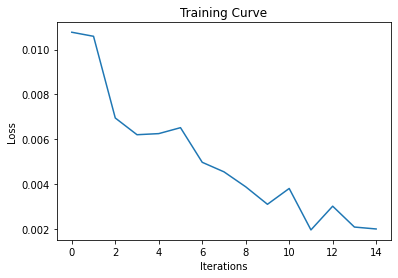

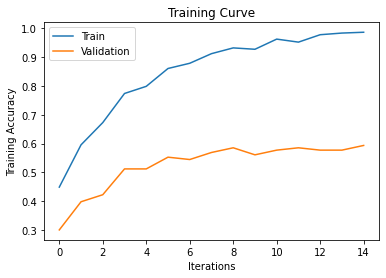

Final Training Accuracy: 0.9857278782112274
Final Validation Accuracy: 0.5934959349593496


In [17]:
# try the training function
model = ANN()
training(model, train, val, batch_size = 128, epochs = 15, lr = 0.001, momentum = 0.9)

In [18]:
test_loaded = torch.utils.data.DataLoader(test, batch_size=1, shuffle = True)
print('test set accuracy is', get_accuracy(model, test_loaded, test_loaded , train = False));

test set accuracy is 0.5238095238095238
